In [1]:
import os
import json
import gc
import re

import numpy as np
import pandas as pd
from scipy.special import rel_entr

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import networkx as nx


In [2]:
df = pd.read_csv('creditcard.csv')
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
fraud_pct = df['Class'].mean() * 100
print(f"\nFraud proportion: {fraud_pct:.4f}% ({df['Class'].sum()} frauds / {len(df)} total)\n")


Fraud proportion: 0.1727% (492 frauds / 284807 total)



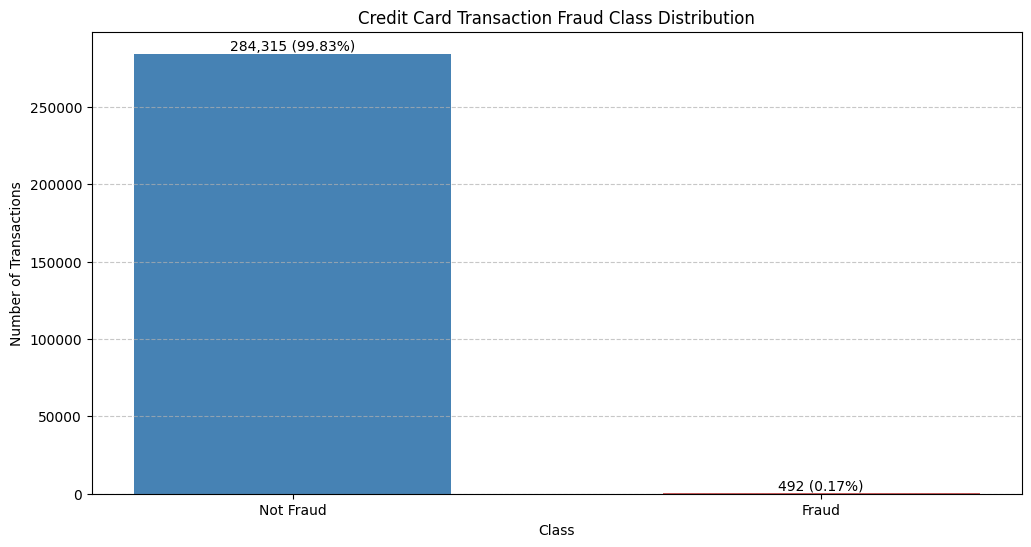

In [4]:
temp = df["Class"].value_counts()
df_d = pd.DataFrame({'Class': temp.index, 'values': temp.values})

total = temp.sum()
df_d['percent'] = df_d['values'] / total * 100

plt.figure(figsize=(12, 6))
bars = plt.bar(df_d['Class'], df_d['values'], color=['steelblue', 'indianred'], width=0.6)
for bar, value, percent in zip(bars, df_d['values'], df_d['percent']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{value:,} ({percent:.2f}%)', ha='center', va='bottom')
plt.title('Credit Card Transaction Fraud Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Transactions')
plt.xticks(df_d['Class'], ['Not Fraud', 'Fraud'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [5]:
df['Hour'] = ((df['Time'] % 86400) // 3600).astype(int)
# night: 0-5 as 'night' by default
df['is_night'] = df['Hour'].isin([0,1,2,3,4,5])

# Fraud counts by hour
hour_summary = df.groupby('Hour')['Class'].agg(['count','sum'])
hour_summary['fraud_rate'] = hour_summary['sum'] / hour_summary['count']

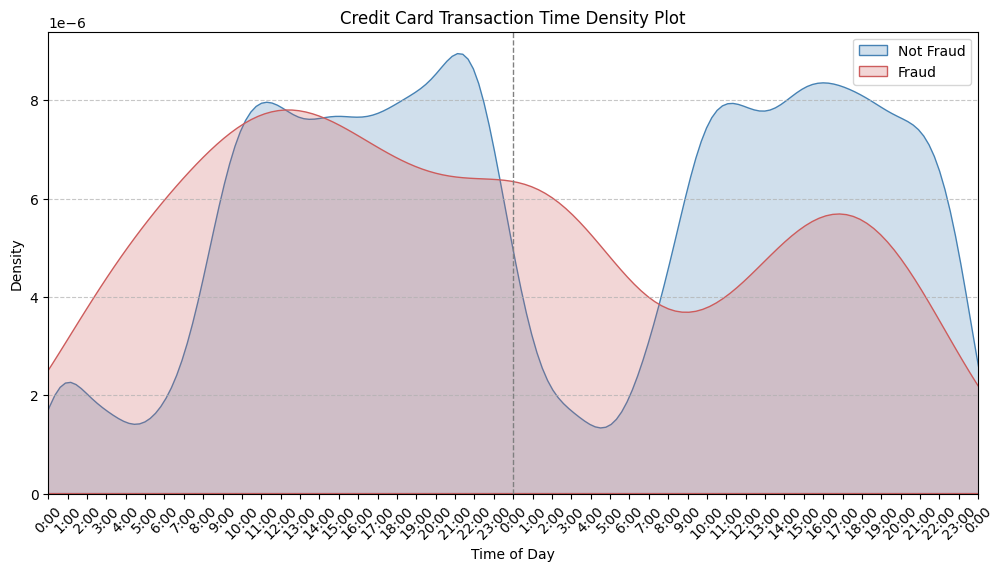

In [6]:
class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

plt.figure(figsize=(12, 6))
sns.kdeplot(class_0, label='Not Fraud', fill=True, color='steelblue')
sns.kdeplot(class_1, label='Fraud', fill=True, color='indianred')
plt.title('Credit Card Transaction Time Density Plot')
plt.xlabel('Time of Day')
plt.ylabel('Density')
plt.xlim(0, max(df["Time"]))
hour_labels = [f'{i % 24}:00' for i in range(49)] # 0:00 to 23:00 repeated twice
plt.xticks(ticks=[i * 3600 for i in range(49)], labels=hour_labels, rotation=45)
plt.axvline(x=24 * 3600, color='gray', linestyle='--', linewidth=1)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

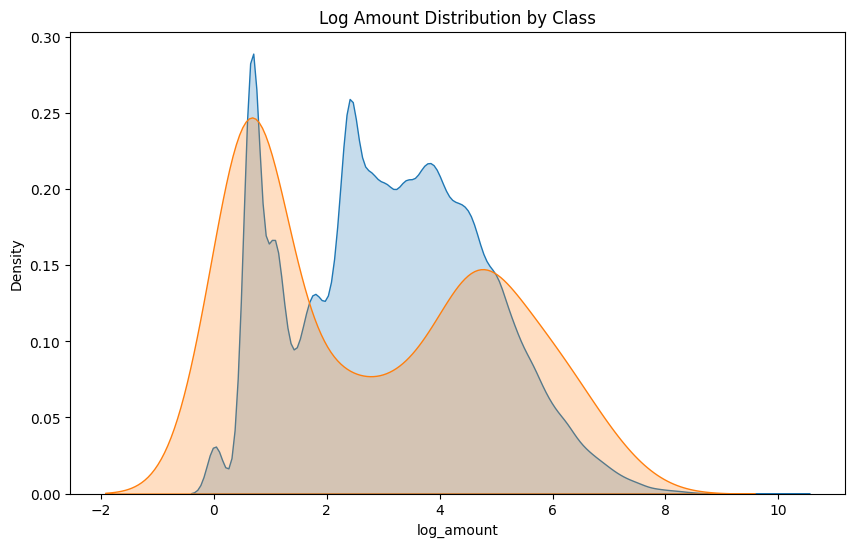

In [7]:

# Log amount
df['log_amount'] = np.log1p(df['Amount'])

# Plot distribution of log amount by class
plt.figure(figsize=(10,6))
sns.kdeplot(df.loc[df['Class']==0, 'log_amount'], label='Not Fraud', fill=True)
sns.kdeplot(df.loc[df['Class']==1, 'log_amount'], label='Fraud', fill=True)
plt.title('Log Amount Distribution by Class')
plt.show()


In [8]:
print("Amount stats for Non-Fraud:")
print(df.loc[df['Class'] == 0, 'Amount'].describe())

print("\nAmount stats for Fraud:")
print(df.loc[df['Class'] == 1, 'Amount'].describe())

Amount stats for Non-Fraud:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Amount stats for Fraud:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


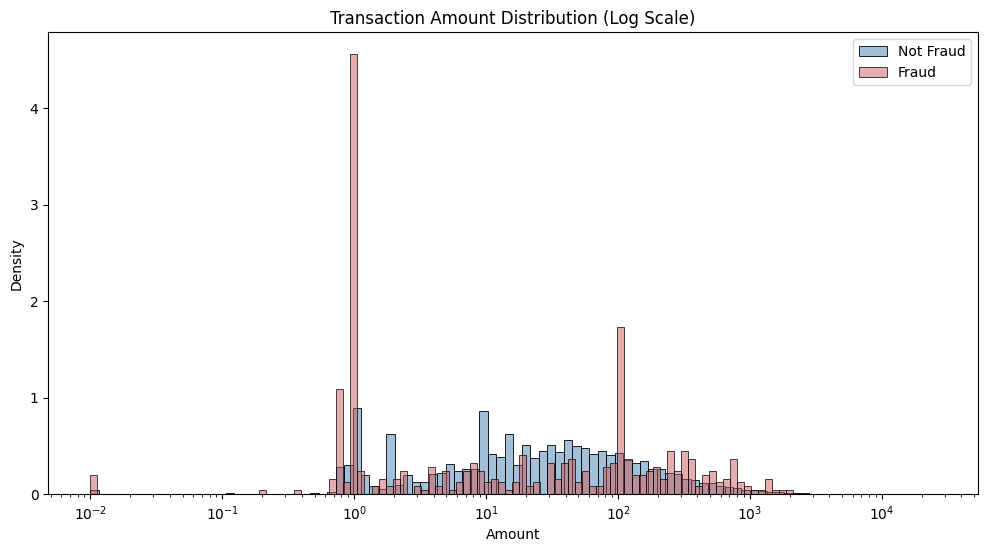

In [10]:
plt.figure(figsize=(12,6))
sns.histplot(df.loc[df['Class'] == 0, 'Amount'], bins=100, color='steelblue', label='Not Fraud', log_scale=True, stat='density', kde=True)
sns.histplot(df.loc[df['Class'] == 1, 'Amount'], bins=100, color='indianred', label='Fraud', log_scale=True, stat='density', kde=True)
plt.title('Transaction Amount Distribution (Log Scale)')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

In [11]:
from scipy.stats import mannwhitneyu

amount_nonfraud = df.loc[df['Class'] == 0, 'Amount']
amount_fraud = df.loc[df['Class'] == 1, 'Amount']

stat, p = mannwhitneyu(amount_nonfraud, amount_fraud)
print(f"Mann-Whitney U Test: statistic={stat}, p-value={p}")

Mann-Whitney U Test: statistic=78049581.0, p-value=8.578472310840218e-06


/tmp/ipython-input-1438285911.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rates = df.groupby('amount_bin')['Class'].mean()


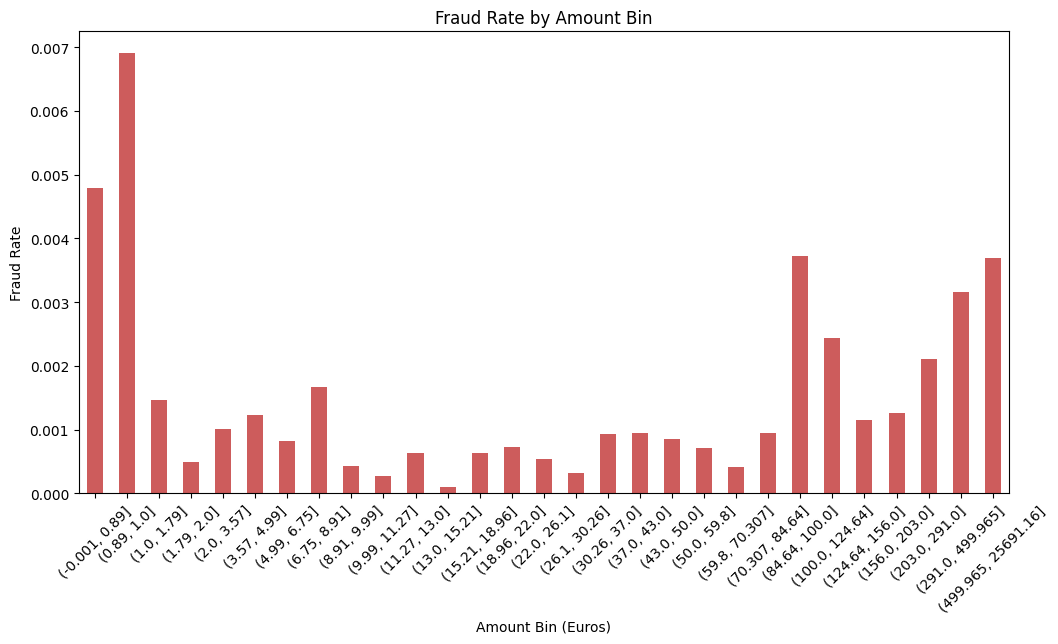

In [12]:
df['amount_bin'] = pd.qcut(df['Amount'], q=30, duplicates='drop')  # 20 quantile bins

fraud_rates = df.groupby('amount_bin')['Class'].mean()

plt.figure(figsize=(12,6))
fraud_rates.plot(kind='bar', color='indianred')
plt.title('Fraud Rate by Amount Bin')
plt.xlabel('Amount Bin (Euros)')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()


In [13]:
corr = df['Amount'].corr(df['Class'])
print(f"Pearson correlation between Amount and Fraud Class: {corr:.4f}")


Pearson correlation between Amount and Fraud Class: 0.0056


In [14]:
corr = df['Time'].corr(df['Class'])
print(f"Pearson correlation between Time and Fraud Class: {corr:.4f}")

Pearson correlation between Time and Fraud Class: -0.0123


In [15]:
amount_thresholds = [1, 10, 50, 100, 500, 1000, 5000, 10000]
for thresh in amount_thresholds:
    above = df[df['Amount'] > thresh]
    below = df[df['Amount'] <= thresh]
    fraud_rate_above = above['Class'].mean()
    fraud_rate_below = below['Class'].mean()
    print(f"Threshold: {thresh:.2f} | Fraud rate above: {fraud_rate_above:.4f} | Fraud rate below: {fraud_rate_below:.6f}")


Threshold: 1.00 | Fraud rate above: 0.0012 | Fraud rate below: 0.005936
Threshold: 10.00 | Fraud rate above: 0.0013 | Fraud rate below: 0.002483
Threshold: 50.00 | Fraud rate above: 0.0020 | Fraud rate below: 0.001602
Threshold: 100.00 | Fraud rate above: 0.0023 | Fraud rate below: 0.001586
Threshold: 500.00 | Fraud rate above: 0.0038 | Fraud rate below: 0.001658
Threshold: 1000.00 | Fraud rate above: 0.0031 | Fraud rate below: 0.001714
Threshold: 5000.00 | Fraud rate above: 0.0000 | Fraud rate below: 0.001728
Threshold: 10000.00 | Fraud rate above: 0.0000 | Fraud rate below: 0.001728


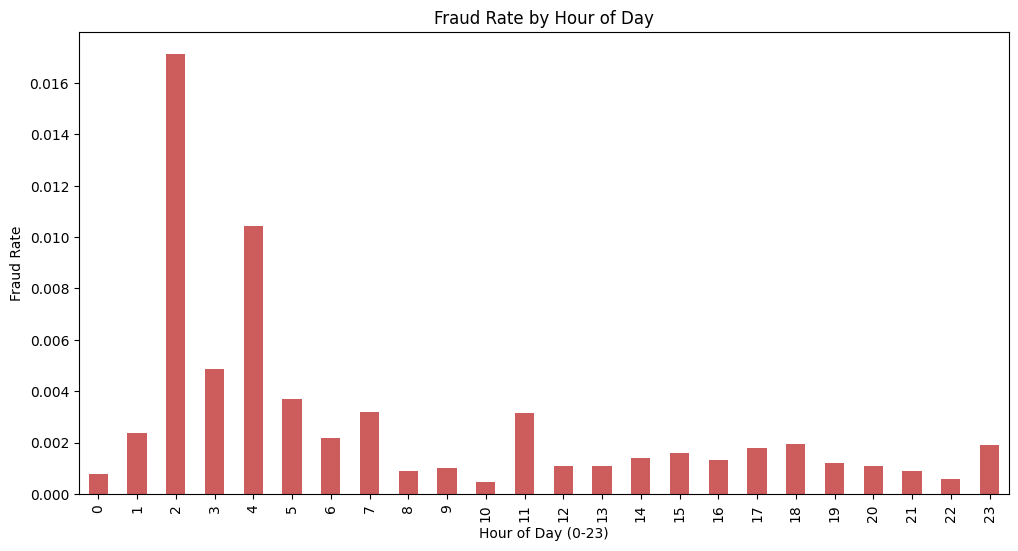

Fraud rate during day (6AM-9PM): 0.0014
Fraud rate during night (10PM-5AM): 0.0031


In [16]:
df['Hour'] = ((df['Time'] % 86400) // 3600).astype(int)  # 0-23 hours

# Fraud rate by hour
hour_fraud_rate = df.groupby('Hour')['Class'].mean()

plt.figure(figsize=(12,6))
hour_fraud_rate.plot(kind='bar', color='indianred')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Fraud Rate')
plt.show()

# Example thresholds to check day vs night
day_hours = list(range(6, 22))  # 6AM to 9PM
night_hours = list(range(0, 6)) + list(range(22, 24))

fraud_day = df[df['Hour'].isin(day_hours)]['Class'].mean()
fraud_night = df[df['Hour'].isin(night_hours)]['Class'].mean()

print(f"Fraud rate during day (6AM-9PM): {fraud_day:.4f}")
print(f"Fraud rate during night (10PM-5AM): {fraud_night:.4f}")


In [19]:
V_cols = [f'V{i}' for i in range(1,29)]
kl_divs = {}
c0 = df[df['Class']==0]
c1 = df[df['Class']==1]
for col in V_cols:
  if col in df.columns:
    x0 = c0[col].values
    x1 = c1[col].values
    min_val = min(x0.min(), x1.min())
    max_val = max(x0.max(), x1.max())
    bins = np.linspace(min_val, max_val, 100)
    p, _ = np.histogram(x0, bins=bins, density=True)
    q, _ = np.histogram(x1, bins=bins, density=True)
    eps = 1e-10
    p += eps
    q += eps
    kl_div = 0.5 * (np.sum(rel_entr(p,q)) + np.sum(rel_entr(q,p)))
    kl_divs[col] = kl_div


# Display top KL features
sorted_kl = sorted(kl_divs.items(), key=lambda x: x[1], reverse=True)
print("Top V-features by symmetric KL:")
for f, k in sorted_kl[:10]:
  print(f"{f}: {k:.4f}")

Top V-features by symmetric KL:
V11: 24.6600
V4: 18.5922
V18: 18.2471
V12: 17.9747
V14: 14.4460
V17: 13.7711
V16: 12.4709
V9: 8.7215
V10: 8.5053
V24: 7.7781
